# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [01:20<00:00, 1083.79it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8458393216133118), ('terrific', 0.8283421993255615), ('good', 0.8198685050010681), ('awesome', 0.8181648850440979), ('excellent', 0.8141458034515381), ('wonderful', 0.7697104215621948), ('perfect', 0.7679648399353027), ('amazing', 0.7204164266586304), ('nice', 0.6973293423652649), ('fabulous', 0.6945580244064331)]
[('greatest', 0.793729841709137), ('tastiest', 0.7467349767684937), ('best', 0.6928790807723999), ('disgusting', 0.6836183071136475), ('terrible', 0.6659383773803711), ('horrible', 0.659453272819519), ('nastiest', 0.6568986177444458), ('closest', 0.6368379592895508), ('awful', 0.6316072344779968), ('nicest', 0.62861168384552)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 87773/87773 [07:57<00:00, 183.71it/s]


87773
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 87773/87773 [2:18:28<00:00, 10.56it/s]  


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [34]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews
#final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (87773, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


In [35]:
# Please write all the code with proper documentation
X=final["CleanedText"]
Y=final["Score"]

In [36]:
#splitting data randomly
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30) # this is random splitting
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.30) # this is random splitting

print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)


(43008,) (43008,)
(18433,) (18433,)
(26332,) (26332,)


In [37]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)

After vectorizations
(43008, 38975) (43008,)
(18433, 38975) (18433,)
(26332, 38975) (26332,)


In [38]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)

X_train_bow = scalar.fit_transform(X_train_bow)
X_test_bow= scalar.transform(X_test_bow)
X_cv_bow=scalar.transform(X_cv_bow)


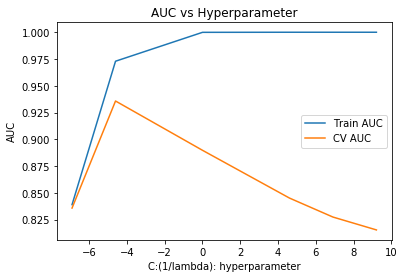

optimal lambda for which auc is maximum :  0.01


In [39]:
#K-fold Cross validation to find alpha i.e hyperparameter tuning
from sklearn.metrics import roc_auc_score
lambda_range=[10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
cv_scores=[]
train_auc = []
cv_auc = []
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
for i in lambda_range:
    LR=LogisticRegression(penalty='l1',C=i)
    LR.fit(X_train_bow, Y_train)
    scores=cross_val_score(LR, X_train_bow,Y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())
    
    Y_train_pred =  LR.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  LR.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    
plt.plot(np.log(lambda_range),train_auc, label='Train AUC')
#plt.scatter(lambda_range, train_auc, label='Train AUC')
plt.plot(np.log(lambda_range), cv_auc, label='CV AUC')
#plt.scatter(lambda_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C:(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()
    
    
optimal_C= lambda_range[cv_scores.index(max(cv_scores))]
print('optimal lambda for which auc is maximum : ',optimal_C)

 # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
   

In [40]:
from sklearn.metrics import accuracy_score
LR_optimal = LogisticRegression(penalty='l1',C = optimal_C,class_weight='balanced')
LR_optimal.fit(X_train_bow,Y_train)
pred = LR_optimal.predict(X_test_bow)
roc_score = metrics.roc_auc_score(Y_train,Y_train_pred)
print("The ROC_SCOre for optimal C = {0} is {1}".format(optimal_C,roc_score))

The ROC_SCOre for optimal C = 0.01 is 0.9999979462579427


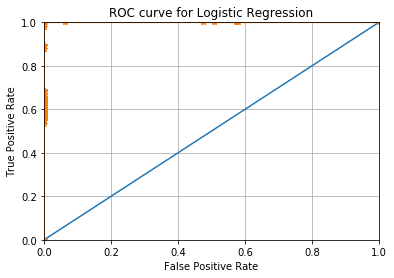

In [41]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,Y_train_pred)
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='*')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

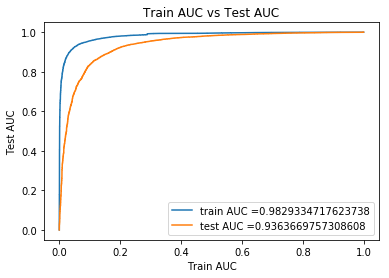

In [42]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, LR_optimal.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, LR_optimal.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title("Train AUC vs Test AUC")
plt.show()

print("="*100)


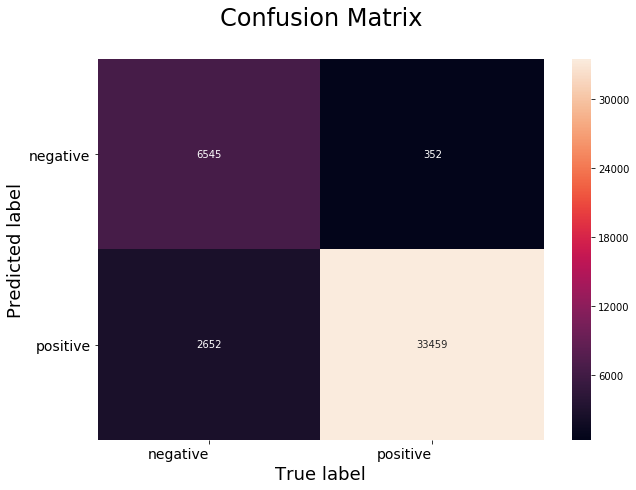

In [43]:
#Draw seaborn heat map for representaion of confusion matrix for train

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,LR_optimal.predict(X_train_bow)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


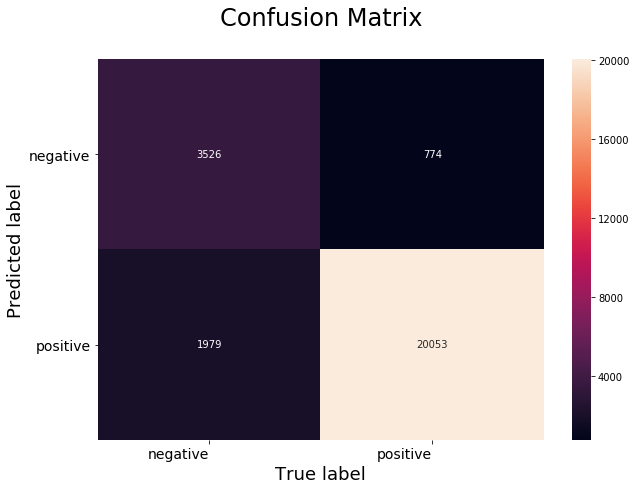

In [44]:
#Draw seaborn heat map for representaion of confusion matrix for test

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,LR_optimal.predict(X_test_bow)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


In [56]:
import scipy as sp
epsilon=np.random.normal(0,0.001)#create noise
#epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)

W_before_epsilon=LR_optimal.coef_#checking weight before adding noise
print("wieght before epsilon",W_before_epsilon)

non_zero = X_train_bow.count_nonzero()#count number of non zero element x_train sparse matrix

from scipy.sparse import csr_matrix,isspmatrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_bow
X_train_indices = X_train_bow.indices
X_train_indptr = X_train_bow.indptr

# Creating a list of same element with repetition
data = [epsilon] * non_zero
Shape = X_train_bow.shape

#creating sparse ,arix of epsilon values
sparse_epsilon=csr_matrix((data,X_train_indices,X_train_indptr),shape=Shape,dtype='float')
isspmatrix(X_train_bow)

#sparse_epsilon.shape
# adding epsilon in to sparse matix
X_train_epsilon=X_train_bow + sparse_epsilon

wieght before epsilon [[0. 0. 0. ... 0. 0. 0.]]


In [59]:
#train model on epsilon added data
LR_epsilon = LogisticRegression(penalty='l1',C = optimal_C)
LR_epsilon.fit(X_train_epsilon,Y_train)

#checking weight after adding epsilon

W_after_epsilon=LR_epsilon.coef_
print("wieght after epsilon",W_after_epsilon)

#addding 10**-6 in weight to avoid division by zero error
W_before_epsilon=W_before_epsilon + 10**-6
W_after_epsilon=W_after_epsilon + 10**-6





wieght after epsilon [[0. 0. 0. ... 0. 0. 0.]]


In [60]:

#Changes in weight after adding epsilon
change_W = ((W_before_epsilon - W_after_epsilon)/(W_before_epsilon))*100
sorted_change_W=np.sort(np.absolute(change_W))[:,::-1]

sorted_change_W[:10]


array([[8.36276148e+05, 4.73142663e+05, 4.68852735e+05, ...,
        8.67942040e-02, 7.64225256e-02, 6.51612368e-02]])

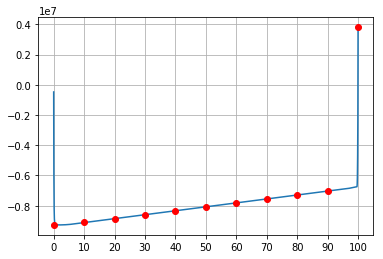

In [61]:
#code reference https://www.kaggle.com/souravdas4/amazon-food-reviews-using-logisticregression

#Ploting the cummulative percentile plot to find the threshold value 

from matplotlib import mlab

d = np.sort(change_W).cumsum()
p = np.array(range(0,101,10))
perc = mlab.prctile(d, p=p)
plt.plot(d)

# Place red dots on the percentiles
plt.plot((len(d)-1) * p/100., perc, 'ro')

# Set tick locations and labels
plt.xticks((len(d)-1) * p/100., map(str, p))

plt.grid()
plt.show()


There is sudden rise from 6th percentile therefore percentile should be checked 

In [62]:
##calculating percentiles from 0 to 100

for i in range(11):
    print(str(i*10)+'th percentile = '+str(np.percentile(sorted_change_W,i)))

0th percentile = 0.06516123677203503
10th percentile = 12.680902568453984
20th percentile = 22.161495217208067
30th percentile = 33.657449184788305
40th percentile = 48.99688450027259
50th percentile = 66.66666666666667
60th percentile = 66.66666666666667
70th percentile = 66.66666666666667
80th percentile = 66.66666666666667
90th percentile = 66.66666666666667
100th percentile = 66.66666666666667


WE SEE THAT THERE IS A SUDDEN JUMP AFTER 99.8 PERCENTILE THUS IT IS TAKEN TO BE THE THRESHOLD



In [111]:
#features=np.where(change_W>np.percentile(change_W,6.1))[1]


In [ ]:
'''names_reviews=count_vect.get_feature_names()
#names_summary=vectorizer.get_feature_names()
for i in features:
    if(i>2443):
        print(names_summary[2443-i],end=" ")
    else:
        print(names_reviews[i],end=" ")
print('\n--------------------------------------------')
print("Total Number of features :",len(features)) 
'''

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [61]:

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(X_train_bow, Y_train);
w = clf.coef_
print(np.count_nonzero(w))


1347


In [64]:

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(X_train_bow, Y_train);
w = clf.coef_
print(np.count_nonzero(w))


53


In [63]:

clf = LogisticRegression(C=10, penalty='l1');
clf.fit(X_train_bow, Y_train);
w = clf.coef_
print(np.count_nonzero(w))


2069


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

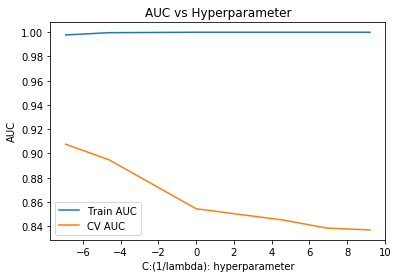

optimal lambda for which auc is maximum :  0.001


In [63]:
#K-fold Cross validation to find alpha i.e hyperparameter tuning
from sklearn.metrics import roc_auc_score
lambda_range=[10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
cv_scores=[]
train_auc = []
cv_auc = []
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
for i in lambda_range:
    LR=LogisticRegression(penalty='l2',C=i)
    LR.fit(X_train_bow, Y_train)
    scores=cross_val_score(LR, X_train_bow,Y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())
    
    Y_train_pred =  LR.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  LR.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    
plt.plot(np.log(lambda_range),train_auc, label='Train AUC')
#plt.scatter(lambda_range, train_auc, label='Train AUC')
plt.plot(np.log(lambda_range), cv_auc, label='CV AUC')
#plt.scatter(lambda_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C:(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()
    
    
optimal_C= lambda_range[cv_scores.index(max(cv_scores))]
print('optimal lambda for which auc is maximum : ',optimal_C)

 # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
   

In [64]:
from sklearn.metrics import accuracy_score
LR_optimal = LogisticRegression(penalty='l2',C = optimal_C)
LR_optimal.fit(X_train_bow,Y_train)
pred = LR_optimal.predict(X_test_bow)
roc_score = metrics.roc_auc_score(Y_train,Y_train_pred)
print("The roc score for optimal C = {0} is {1}".format(optimal_C,roc_score))

The roc score for optimal C = 0.001 is 0.9999979462579428


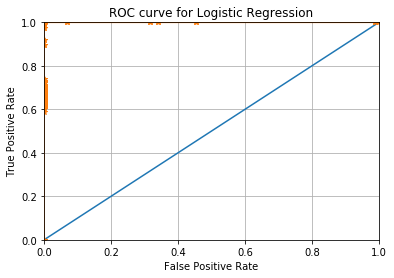

In [65]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,Y_train_pred)
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='*')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

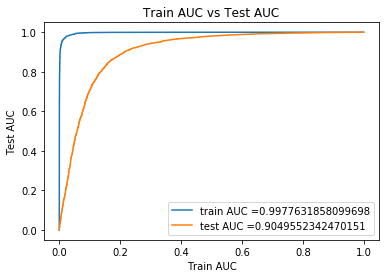

In [66]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, LR_optimal.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, LR_optimal.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title("Train AUC vs Test AUC")
plt.show()

print("="*100)


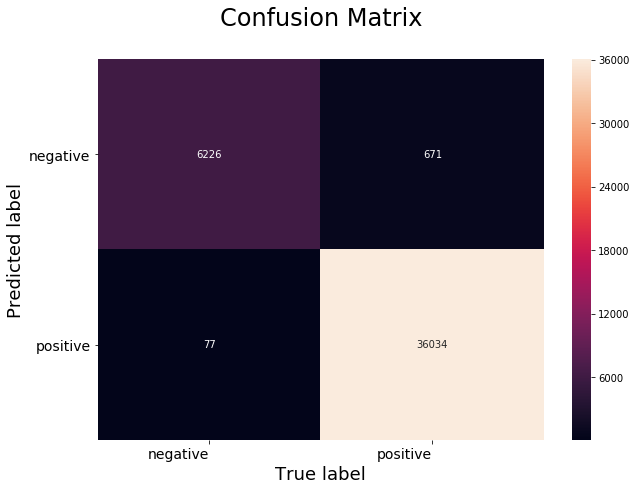

In [67]:
#Draw seaborn heat map for representaion of confusion matrix for train

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,LR_optimal.predict(X_train_bow)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


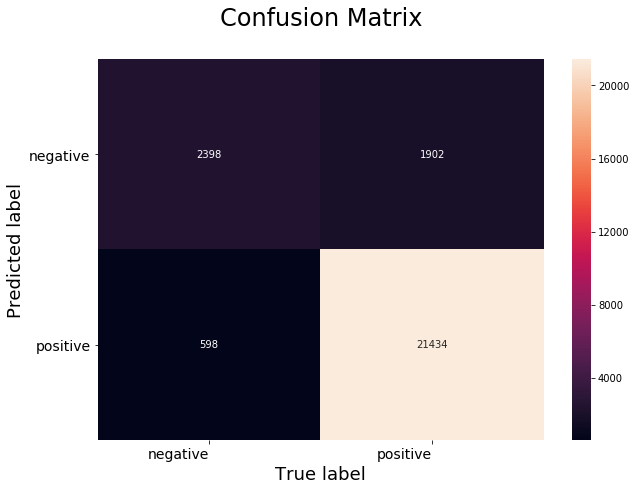

In [68]:
#Draw seaborn heat map for representaion of confusion matrix train

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,LR_optimal.predict(X_test_bow)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [69]:
# Please write all the code with proper documentation
import scipy as sp
epsilon=np.random.normal(0,0.001)#create noise
#epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)

W_before_epsilon=LR_optimal.coef_#checking weight before adding noise
print("wieght before epsilon",W_before_epsilon)

non_zero = X_train_bow.count_nonzero()#count number of non zero element x_train sparse matrix

from scipy.sparse import csr_matrix,isspmatrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_bow
X_train_indices = X_train_bow.indices
X_train_indptr = X_train_bow.indptr

# Creating a list of same element with repetition
data = [epsilon] * non_zero
Shape = X_train_bow.shape

#creating sparse ,arix of epsilon values
sparse_epsilon=csr_matrix((data,X_train_indices,X_train_indptr),shape=Shape,dtype='float')
isspmatrix(X_train_bow)

#sparse_epsilon.shape
# adding epsilon in to sparse matix
X_train_epsilon=X_train_bow + sparse_epsilon

wieght before epsilon [[-0.01020049  0.00464242  0.00548958 ...  0.00131558  0.00024484
  -0.01291023]]


In [70]:
#train model on epsilon added data
LR_epsilon = LogisticRegression(penalty='l2',C = optimal_C)
LR_epsilon.fit(X_train_epsilon,Y_train)

#checking weight after adding epsilon

W_after_epsilon=LR_epsilon.coef_
print("wieght after epsilon",W_after_epsilon)

#addding 10**-6 in weight to avoid division by zero error
W_before_epsilon=W_before_epsilon + 10**-6
W_after_epsilon=W_after_epsilon + 10**-6





wieght after epsilon [[-0.01020056  0.00464241  0.00548964 ...  0.00131561  0.00024482
  -0.01291032]]


In [71]:

#Changes in weight after adding epsilon
change_W = ((W_before_epsilon - W_after_epsilon)/(W_before_epsilon))*100
sorted_change_W=np.sort(np.absolute(change_W))[:,::-1]

sorted_change_W[:10]


array([[1.94815112e+03, 1.94815112e+03, 1.94815112e+03, ...,
        4.71081503e-08, 4.71081503e-08, 4.71081503e-08]])

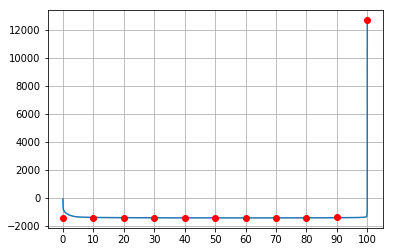

In [72]:
#code reference https://www.kaggle.com/souravdas4/amazon-food-reviews-using-logisticregression

#Ploting the cummulative percentile plot to find the threshold value 

from matplotlib import mlab

d = np.sort(change_W).cumsum()
p = np.array(range(0,101,10))
perc = mlab.prctile(d, p=p)
plt.plot(d)

# Place red dots on the percentiles
plt.plot((len(d)-1) * p/100., perc, 'ro')

# Set tick locations and labels
plt.xticks((len(d)-1) * p/100., map(str, p))
plt.grid()
plt.show()


In [73]:
##calculating percentiles from 0 to 100

for i in range(11):
    print(str(i*10)+'th percentile = '+str(np.percentile(sorted_change_W,i*10)))

0th percentile = 4.710815033706291e-08
10th percentile = 0.00019147895184359464
20th percentile = 0.0004024444026747095
30th percentile = 0.0006419325879897476
40th percentile = 0.0009369982045033783
50th percentile = 0.0013434964829588116
60th percentile = 0.0019505256432975297
70th percentile = 0.0029813057077914713
80th percentile = 0.005248396165191956
90th percentile = 0.015993759220020016
100th percentile = 1948.1511248007437


In [74]:
##calculating percentiles from 90 to 100

for i in range(90,101):
    print(str(i)+'th percentile = '+str(np.percentile(sorted_change_W,i)))

90th percentile = 0.015993759220020016
91th percentile = 0.019685780591672072
92th percentile = 0.0252703065444109
93th percentile = 0.03127158157444328
94th percentile = 0.045171671775778376
95th percentile = 0.0716017459327132
96th percentile = 0.11449606658968056
97th percentile = 0.1805980722206111
98th percentile = 0.31066942058222186
99th percentile = 0.5819708838456424
100th percentile = 1948.1511248007437


In [75]:
##calculating percentiles from 0 to 100

for i in np.arange(99.1,100,0.1):
    print(str(i)+'th percentile = '+str(np.percentile(sorted_change_W,i)))

99.1th percentile = 0.6472959086905671
99.19999999999999th percentile = 0.9047762667830319
99.29999999999998th percentile = 0.9118901234726879
99.39999999999998th percentile = 0.9160015246906201
99.49999999999997th percentile = 1.0753435772797202
99.59999999999997th percentile = 1.4900931518651017
99.69999999999996th percentile = 2.5706185884999075
99.79999999999995th percentile = 3.8511242907671135
99.89999999999995th percentile = 8.966689301502804
99.99999999999994th percentile = 1948.1511248007437


In [76]:
features=np.where(change_W>np.percentile(change_W,99.8))[1]


In [77]:
names_reviews=vectorizer.get_feature_names()
names_summary=vectorizer.get_feature_names()
for i in features:
    if(i>22574):
        print(names_summary[22574-i],end=" ")
    else:
        print(names_reviews[i],end=" ")
print('\n--------------------------------------------')
print("Total Number of features :",len(features))

alia alkaloids althos antirheumatic arable availabily cardiovascular carnivores cerevesiae closeness coated cobble complexes compounding contexts courts cuprecommended decorum designating dumas facimilies faecieum faithfulness feedinglbs fileted guarani inexplicable isb iu kgascorbic kghydrochloridetotal kgvitamin licheniformis magnificient manifold mati melanine miffed monarch mongut musketters narrowly neighbourhood zapp yumminess vents unique trick transfat transactions toffee throws thre territorial teaness taastes spice sometype shipments settlements settled saved riboflavin reliquify rainforests psthis pso pom pears overwatered omen oiliness oad noticed nothing notfind notfall 
--------------------------------------------
Total Number of features : 77


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [80]:
# Please write all the code with proper documentation

weight=LR.coef_
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(features[i])

Top 10 positive features :


IndexError: index 14775 is out of bounds for axis 0 with size 77

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [81]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = coefs_with_fns[:n]

    print("\t\tTop 10 important Negative features\n")

    for coef_1 in top:
        print("\t%.4f\t%-15s" % coef_1)
        
show_most_informative_features(vectorizer,clf)


NameError: name 'clf' is not defined

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [82]:
#Splitting data randomly
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.30)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.30)

print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

(43008,) (43008,)
(18433,) (18433,)
(26332,) (26332,)


In [83]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(X_train)
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After TFIDF vectorization")
print(X_train_tfidf.shape,Y_train.shape)
print(X_cv_tfidf.shape,Y_cv.shape)
print(X_test_tfidf.shape,Y_test.shape)


After TFIDF vectorization
(43008, 38727) (43008,)
(18433, 38727) (18433,)
(26332, 38727) (26332,)


In [84]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)

X_train_tfidf = scalar.fit_transform(X_train_tfidf)
X_test_tfidf= scalar.transform(X_test_tfidf)
X_cv_tfidf=scalar.transform(X_cv_tfidf)


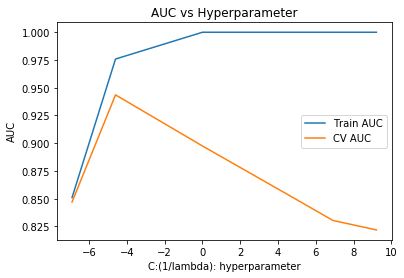

optimal lambda for which auc is maximum :  0.01


In [85]:
#K-fold Cross validation to find alpha i.e hyperparameter tuning
from sklearn.metrics import roc_auc_score
lambda_range=[10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
cv_scores=[]
train_auc = []
cv_auc = []
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
for i in lambda_range:
    LR=LogisticRegression(penalty='l1',C=i)
    LR.fit(X_train_tfidf, Y_train)
    scores=cross_val_score(LR, X_train_tfidf,Y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())
    
    Y_train_pred =  LR.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  LR.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    
plt.plot(np.log(lambda_range),train_auc, label='Train AUC')
#plt.scatter(lambda_range, train_auc, label='Train AUC')
plt.plot(np.log(lambda_range), cv_auc, label='CV AUC')
#plt.scatter(lambda_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C:(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()
    
    
optimal_C= lambda_range[cv_scores.index(max(cv_scores))]
print('optimal lambda for which auc is maximum : ',optimal_C)

 # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
   

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [87]:
LR_optimal=LogisticRegression(penalty='l1',C=optimal_C)
LR_optimal.fit(X_train_tfidf,Y_train)
pred = LR_optimal.predict(X_test_tfidf)


In [88]:
print(metrics.roc_auc_score(Y_train,Y_train_pred))

0.9999982014782176


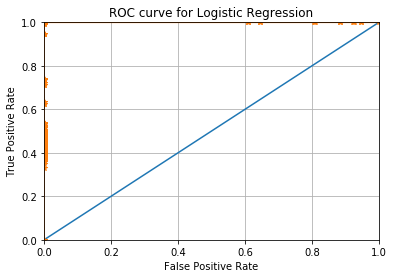

In [89]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,Y_train_pred)
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='*')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

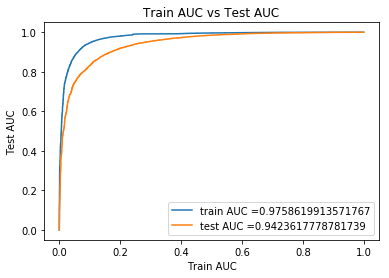

In [90]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, LR_optimal.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, LR_optimal.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title("Train AUC vs Test AUC")
plt.show()

print("="*100)


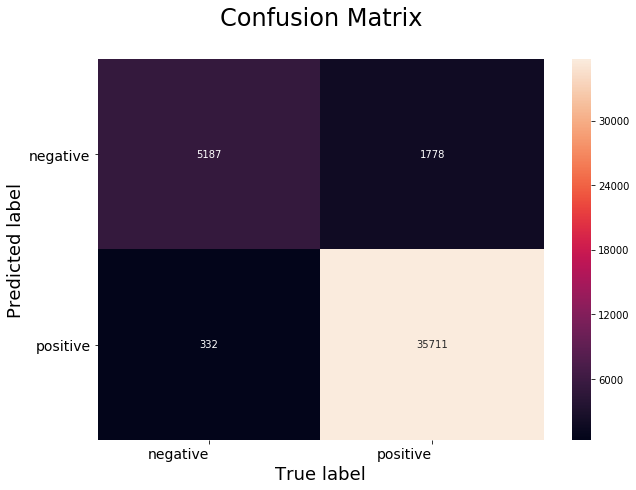

In [91]:
#Draw seaborn heat map for representaion of confusion matrix for train

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,LR_optimal.predict(X_train_tfidf)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


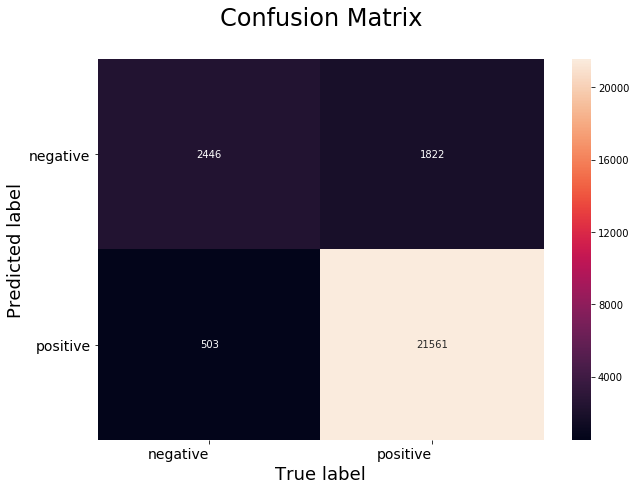

In [92]:
#Draw seaborn heat map for representaion of confusion matrix for test

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,LR_optimal.predict(X_test_tfidf)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

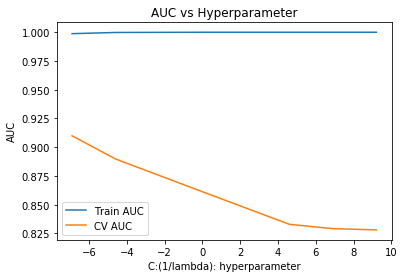

optimal lambda for which auc is maximum :  0.001


In [93]:
#K-fold Cross validation to find alpha i.e hyperparameter tuning
from sklearn.metrics import roc_auc_score
lambda_range=[10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
cv_scores=[]
train_auc = []
cv_auc = []
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
for i in lambda_range:
    LR=LogisticRegression(penalty='l2',C=i)
    LR.fit(X_train_tfidf, Y_train)
    scores=cross_val_score(LR, X_train_tfidf,Y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())
    
    Y_train_pred =  LR.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  LR.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    
plt.plot(np.log(lambda_range),train_auc, label='Train AUC')
#plt.scatter(lambda_range, train_auc, label='Train AUC')
plt.plot(np.log(lambda_range), cv_auc, label='CV AUC')
#plt.scatter(lambda_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C:(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()
    
    
optimal_C= lambda_range[cv_scores.index(max(cv_scores))]
print('optimal lambda for which auc is maximum : ',optimal_C)

 # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
   

In [94]:
# Please write all the code with proper documentation
LR_optimal=LogisticRegression(penalty='l2',C=optimal_C)
LR_optimal.fit(X_train_tfidf,Y_train)
pred = LR_optimal.predict(X_test_tfidf)
roc_score=metrics.roc_auc_score(Y_train,Y_train_pred)
print("The roc_score for optimal C = {0} is {1}".format(optimal_C,roc_score))

The roc_score for optimal C = 0.001 is 0.9999982014782176


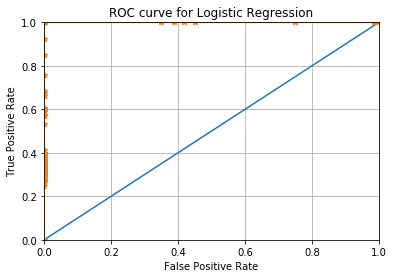

In [95]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,Y_train_pred)
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='*')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

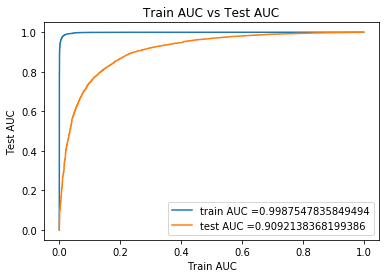

In [96]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, LR_optimal.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, LR_optimal.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title("Train AUC vs Test AUC")
plt.show()

print("="*100)


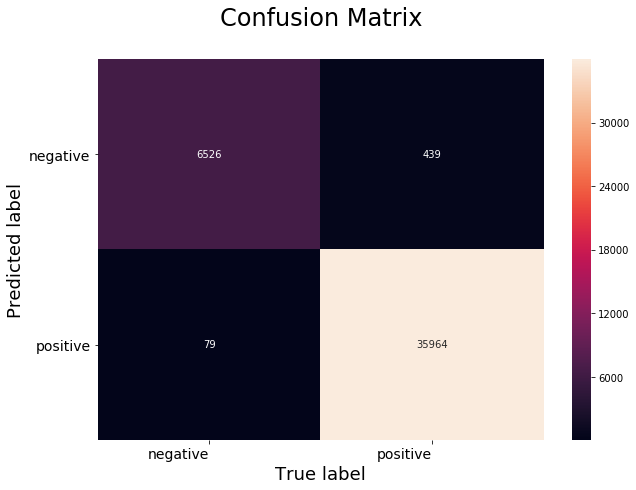

In [97]:
#Draw seaborn heat map for representaion of confusion matrix for train

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,LR_optimal.predict(X_train_tfidf)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


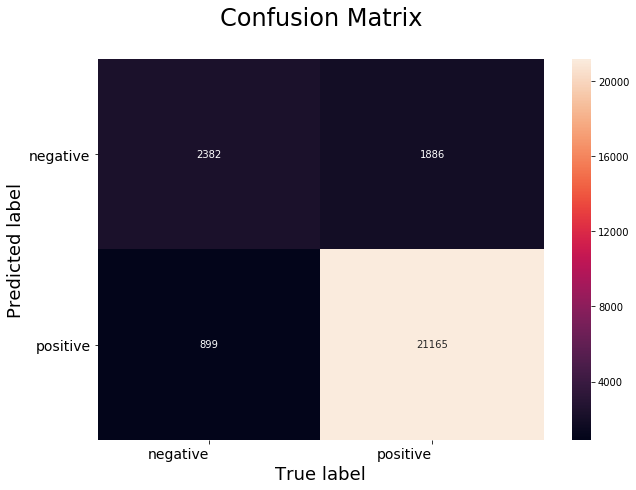

In [98]:
#Draw seaborn heat map for representaion of confusion matrix for test

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,LR_optimal.predict(X_test_tfidf)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [150]:
# Please write all the code with proper documentation
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def show_most_informative_features(vectorizer,LR_optimal, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(LR_optimal.coef_[0], feature_names))
    top =coefs_with_fns[:-(n + 1):-1]
    print("\t\tTop 10 important positive features\n")
    for coef_1 in top:
        print("\t%.4f\t%-15s" % coef_1)
show_most_informative_features(vectorizer,LR_optimal)


		Top 10 important positive features

	4.7631	grainless      
	3.1649	lookes         
	2.8762	berries        
	2.7374	global         
	2.6900	defies         
	2.2314	nobody         
	2.2250	perusing       
	2.1133	fennel         
	1.9492	evaporate      
	1.8607	loose          


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [151]:
# Please write all the code with proper documentation
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(vectorizer, LR_optimal, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(LR_optimal.coef_[0], feature_names))
    top = coefs_with_fns[:n]

    print("\t\tTop 10 important Negative features\n")

    for coef_1 in top:
        print("\t%.4f\t%-15s" % coef_1)
        
show_most_informative_features(vectorizer,LR_optimal)


		Top 10 important Negative features

	-5.8685	nothicker      
	-2.9838	dinner         
	-2.6153	erase          
	-2.4727	awesomeness    
	-2.4146	dinners        
	-2.1310	awarding       
	-2.1278	ya             
	-2.1015	welll          
	-2.0836	backpacking    
	-1.7851	textures       


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [99]:
#Splitting data randomly
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.30)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.30)

print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

(43008,) (43008,)
(18433,) (18433,)
(26332,) (26332,)


In [ ]:
#Please write all the code with proper documentation
#word2vec for train
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

#for cross validation we can use same w2v models and w2v words
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))   

#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 43008/43008 [04:39<00:00, 154.03it/s]


43008
50


100%|██████████| 18433/18433 [02:00<00:00, 153.24it/s]


18433
50


 88%|████████▊ | 23255/26332 [02:40<00:20, 148.67it/s]

In [101]:
X_train_w2v=sent_vectors_train
X_cv_w2v=sent_vectors_cv
X_test_w2v=sent_vectors_test

print("After vectorization")
#len(X_train_w2v,Y_train)


After vectorization


In [103]:
#K-fold Cross validation to find alpha i.e hyperparameter tuning
lambda_range=np.arange(10**-2,10**2,10)

cv_scores=[]

for i in lambda_range:
    LR=LogisticRegression(penalty='l1',C=i)
    scores=cross_val_score(LR, X_train_w2v,Y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())

In [104]:
#misclassification error
MSE=[1- x for x in cv_scores]

# determine best hyperparameter

optimal_C=lambda_range[MSE.index(min(MSE))]
print('\nThe optimal value of lambda is %.3f.' % optimal_C)


The optimal value of lambda is 70.010.


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [105]:
LR_optimal=LogisticRegression(penalty='l1',C=optimal_C)
LR_optimal.fit(X_train_w2v,Y_train)
pred = LR_optimal.predict(X_test_w2v)


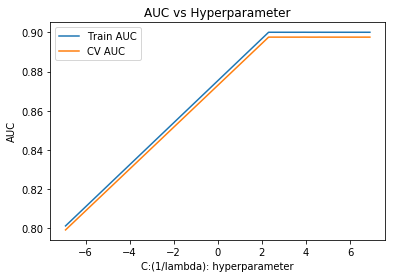

In [106]:
train_auc=[]
cv_auc=[]
lambda_range=np.arange(10**-3,10**3,10)
for i in lambda_range:
    LR=LogisticRegression(penalty='l1',C=i)
    LR.fit(X_train_w2v,Y_train)
    
    Y_train_pred =  LR.predict_proba(X_train_w2v)[:,1]
    Y_cv_pred =  LR.predict_proba(X_cv_w2v)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    
plt.plot(np.log(lambda_range), train_auc, label='Train AUC')
#plt.scatter(lambda_range, train_auc, label='Train AUC')
plt.plot(np.log(lambda_range), cv_auc, label='CV AUC')
#plt.scatter(lambda_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C:(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()
    

In [107]:
print(metrics.roc_auc_score(Y_train,Y_train_pred))

0.9001089436531269


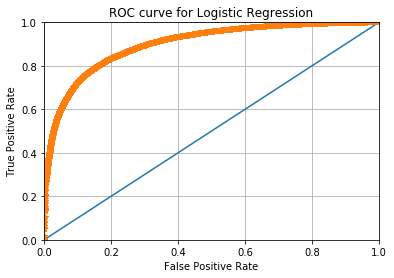

In [108]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,Y_train_pred)
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='*')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

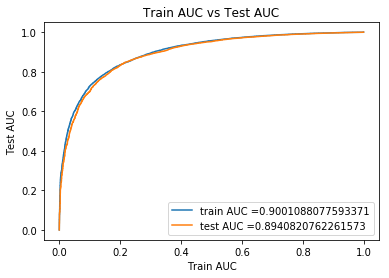

In [109]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, LR_optimal.predict_proba(X_train_w2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, LR_optimal.predict_proba(X_test_w2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title("Train AUC vs Test AUC")
plt.show()

print("="*100)


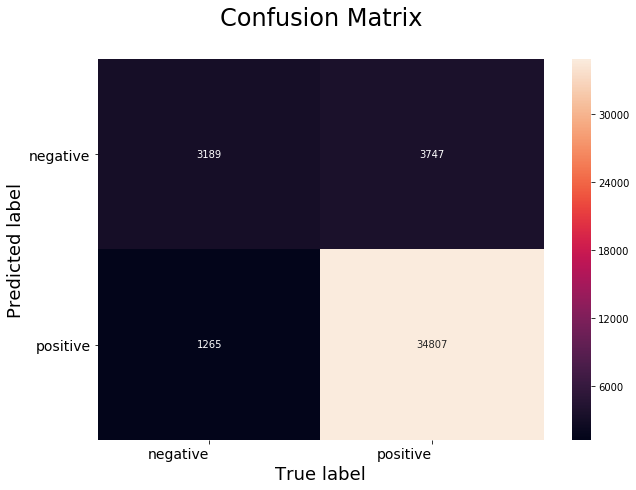

In [110]:
#Draw seaborn heat map for representaion of confusion matrix for train

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,LR_optimal.predict(X_train_w2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


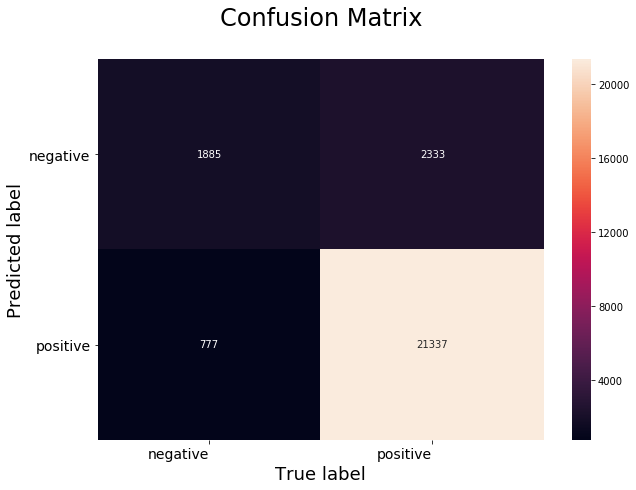

In [111]:
#Draw seaborn heat map for representaion of confusion matrix for test

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,LR_optimal.predict(X_test_w2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [112]:
# Please write all the code with proper documentation
LR_optimal=LogisticRegression(penalty='l2',C=optimal_C)
LR_optimal.fit(X_train_w2v,Y_train)
pred = LR_optimal.predict(X_test_w2v)
acc=accuracy_score(Y_test,pred)
print("The accuracy for optimal C = {0} is {1}".format(optimal_C,acc))

The accuracy for optimal C = 70.01 is 0.8819307306699073


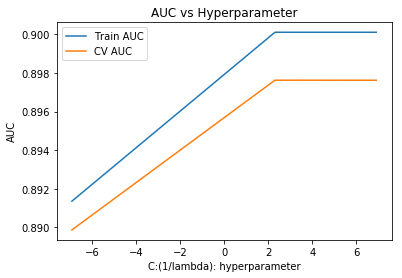

In [113]:
train_auc=[]
cv_auc=[]
lambda_range=np.arange(10**-3,10**3,10)
for i in lambda_range:
    LR=LogisticRegression(penalty='l2',C=i)
    LR.fit(X_train_w2v,Y_train)
    
    Y_train_pred =  LR.predict_proba(X_train_w2v)[:,1]
    Y_cv_pred =  LR.predict_proba(X_cv_w2v)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    
plt.plot(np.log(lambda_range), train_auc, label='Train AUC')
#plt.scatter(lambda_range, train_auc, label='Train AUC')
plt.plot(np.log(lambda_range), cv_auc, label='CV AUC')
#plt.scatter(lambda_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C:(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()
    

In [114]:
print(metrics.roc_auc_score(Y_train,Y_train_pred))

0.9001142315202991


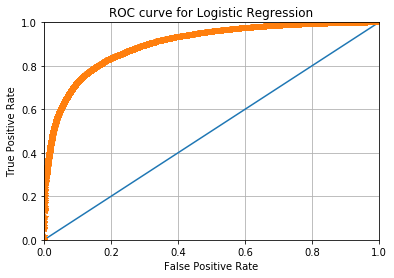

In [115]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,Y_train_pred)
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='*')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

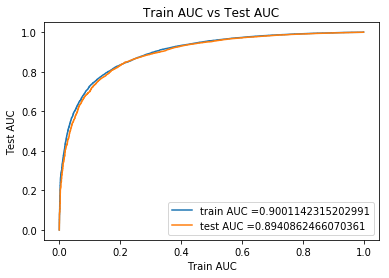

In [116]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, LR_optimal.predict_proba(X_train_w2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, LR_optimal.predict_proba(X_test_w2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title("Train AUC vs Test AUC")
plt.show()

print("="*100)


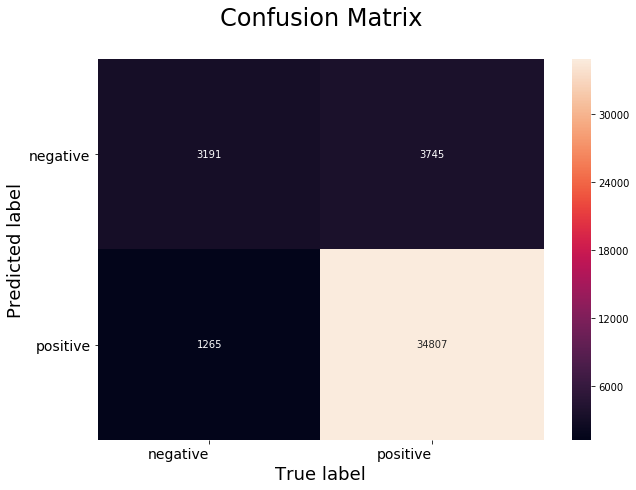

In [117]:
#Draw seaborn heat map for representaion of confusion matrix for train

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,LR_optimal.predict(X_train_w2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


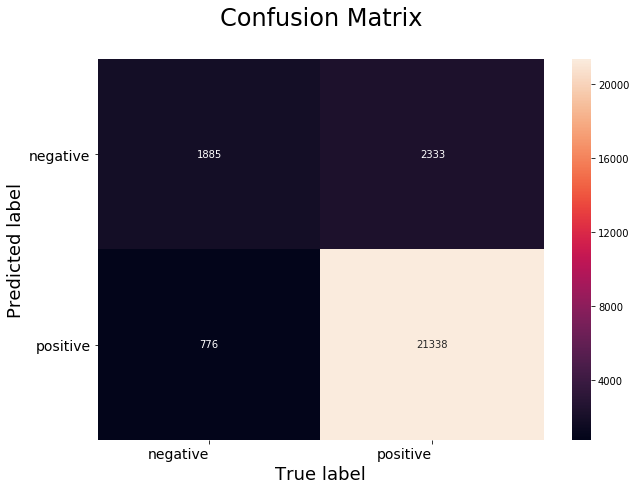

In [118]:
#Draw seaborn heat map for representaion of confusion matrix for test

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,LR_optimal.predict(X_test_w2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [119]:
#Splitting data randomly
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.30)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.30)

print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

(43008,) (43008,)
(18433,) (18433,)
(26332,) (26332,)


In [120]:
# Please write all the code with proper documentation
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
tf_idf_matrix=tf_idf_vect.fit_transform(X_train)
tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#for cross validation data and test we will use same words and models of train

list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

#for test data

list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1


100%|██████████| 26332/26332 [02:11<00:00, 200.55it/s]


In [123]:
X_train_tfw2v=tfidf_sent_vectors_train
X_cv_tfw2v=tfidf_sent_vectors_cv
X_test_tfw2v=tfidf_sent_vectors_test


In [124]:
#K-fold Cross validation to find alpha i.e hyperparameter tuning
lambda_range=np.arange(10**-2,10**2,10)

cv_scores=[]

for i in lambda_range:
    LR=LogisticRegression(penalty='l1',C=i)
    scores=cross_val_score(LR, X_train_tfw2v,Y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())

In [125]:
#misclassification error
MSE=[1- x for x in cv_scores]

# determine best hyperparameter

optimal_C=lambda_range[MSE.index(min(MSE))]
print('\nThe optimal value of lambda is %.3f.' % optimal_C)


The optimal value of lambda is 40.010.


### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [126]:
# Please write all the code with proper documentation
LR_optimal=LogisticRegression(penalty='l1',C=optimal_C)
LR_optimal.fit(X_train_tfw2v,Y_train)
pred = LR_optimal.predict(X_test_tfw2v)


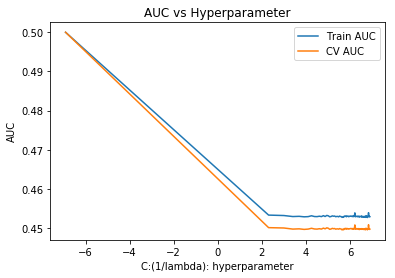

In [127]:
train_auc=[]
cv_auc=[]
lambda_range=np.arange(10**-3,10**3,10)
for i in lambda_range:
    LR=LogisticRegression(penalty='l1',C=i)
    LR.fit(X_train_w2v,Y_train)
    
    Y_train_pred =  LR.predict_proba(X_train_tfw2v)[:,1]
    Y_cv_pred =  LR.predict_proba(X_cv_tfw2v)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    
plt.plot(np.log(lambda_range), train_auc, label='Train AUC')
#plt.scatter(lambda_range, train_auc, label='Train AUC')
plt.plot(np.log(lambda_range), cv_auc, label='CV AUC')
#plt.scatter(lambda_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C:(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()
    

In [128]:
print(metrics.roc_auc_score(Y_train,Y_train_pred))

0.4529175237857884


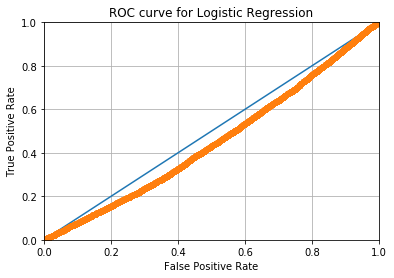

In [129]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,Y_train_pred)
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='*')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

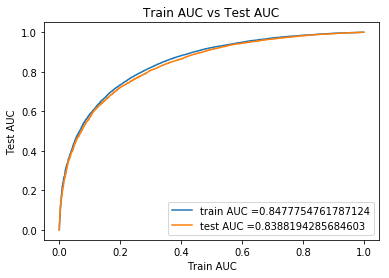

In [130]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, LR_optimal.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, LR_optimal.predict_proba(X_test_tfw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title("Train AUC vs Test AUC")
plt.show()

print("="*100)


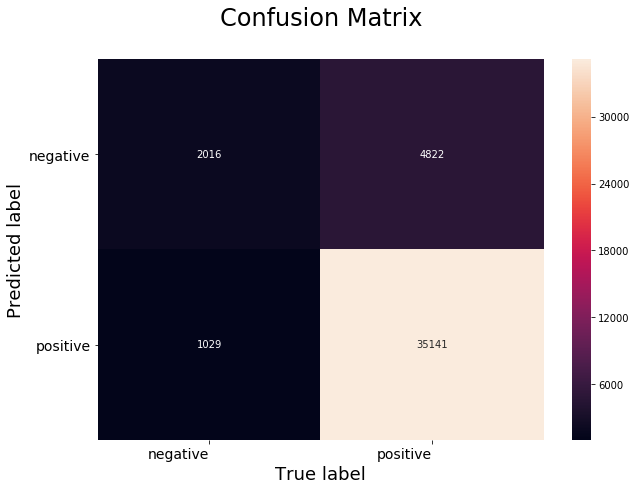

In [131]:
#Draw seaborn heat map for representaion of confusion matrix for train

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,LR_optimal.predict(X_train_tfw2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


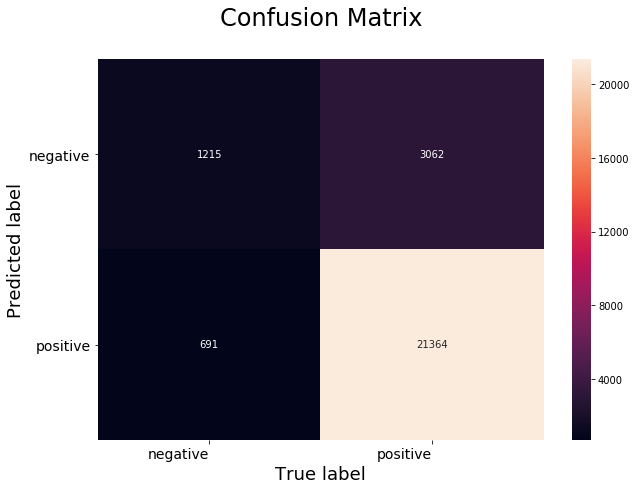

In [132]:
#Draw seaborn heat map for representaion of confusion matrix for test

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,LR_optimal.predict(X_test_tfw2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [133]:
# Please write all the code with proper documentation
LR_optimal=LogisticRegression(penalty='l2',C=optimal_C)
LR_optimal.fit(X_train_tfw2v,Y_train)
pred = LR_optimal.predict(X_test_tfw2v)


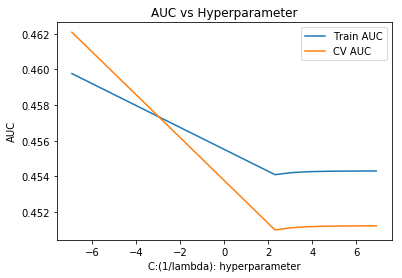

In [134]:
train_auc=[]
cv_auc=[]
lambda_range=np.arange(10**-3,10**3,10)
for i in lambda_range:
    LR=LogisticRegression(penalty='l2',C=i)
    LR.fit(X_train_w2v,Y_train)
    
    Y_train_pred =  LR.predict_proba(X_train_tfw2v)[:,1]
    Y_cv_pred =  LR.predict_proba(X_cv_tfw2v)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    
plt.plot(np.log(lambda_range), train_auc, label='Train AUC')
#plt.scatter(lambda_range, train_auc, label='Train AUC')
plt.plot(np.log(lambda_range), cv_auc, label='CV AUC')
#plt.scatter(lambda_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C:(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

In [135]:
print(metrics.roc_auc_score(Y_train,Y_train_pred))

0.4542976772856849


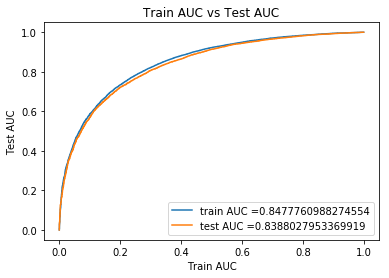

In [136]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, LR_optimal.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, LR_optimal.predict_proba(X_test_tfw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title("Train AUC vs Test AUC")
plt.show()

print("="*100)


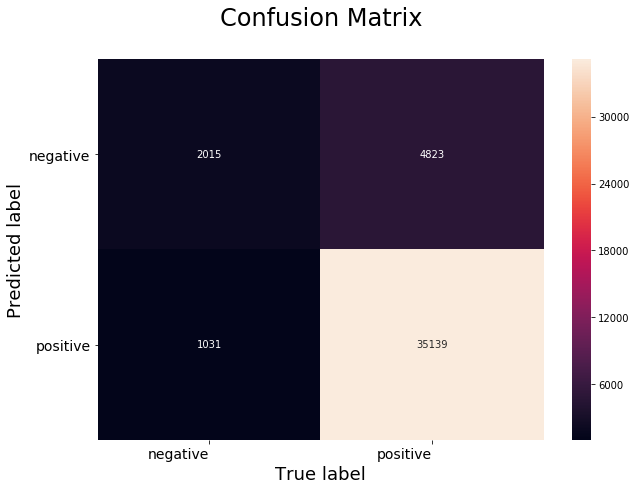

In [137]:
#Draw seaborn heat map for representaion of confusion matrix for train

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,LR_optimal.predict(X_train_tfw2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

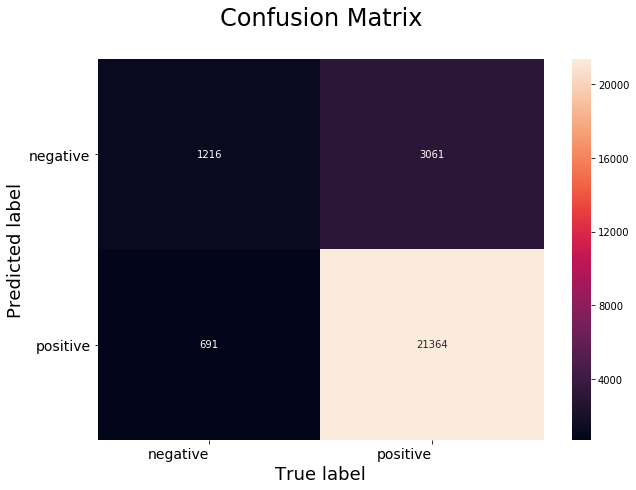

In [138]:
#Draw seaborn heat map for representaion of confusion matrix for test

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,LR_optimal.predict(X_test_tfw2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


# [6] Conclusions

In [139]:
from prettytable import PrettyTable
names=["brute_BOW","brute_TF_IDF","brute_w2v","brute_tfw2v","kd_bow","kd_tfidf","kd_w2v","kd_tfw2v"]

optimal_k = [45,49,45,47,43,31,49,49]


train_acc=[0.77,0.87,0.89,0.84,0.81,0.84,0.82,0.85]


test_acc=[0.65,0.50,0.85,0.81,0.78,0.80,0.86,0.80]



index = [1,2,3,4,5,6,7,8]
# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("Index.",index)
ptable.add_column("Model",names)
ptable.add_column("Best_K",optimal_k)
ptable.add_column("Training_Accuracy",train_acc)
ptable.add_column("Test_Accuracy",test_acc)

print(ptable)